In [33]:
# Import all libraries regarding torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde, lognorm
import os
from torch.utils.data import Dataset, DataLoader
import time
import shutil

In [34]:
# Reading from RSA_input.csv
df = pd.read_csv('RSA_input.csv')
grain_R = df["grain_R"]
grain_asp = df["grain_asp"]
print(len(grain_R)) # length 30218
print(len(grain_asp)) # length 30218

# Combined into numpy shape (30218, 2)
grainsData = np.column_stack((grain_R, grain_asp))
print(grainsData.shape)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

30218
30218
(30218, 2)


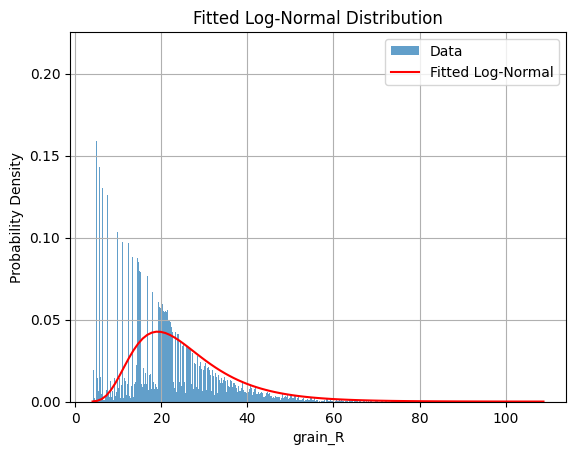

In [35]:

# Compute the histogram of grain_R
counts, bin_edges = np.histogram(grain_R, bins=10, density=True)

# Create the histogram plot
plt.hist(grain_R, bins=1000, density=True, alpha=0.7, label='Data')

# Fit a log-normal distribution to the data
params = lognorm.fit(grain_R)

# Extract the parameters
sigma = params[0]
mu = np.log(params[2])

# Generate x values for the plot
x = np.linspace(min(grain_R), max(grain_R), 100)

# Compute the fitted log-normal PDF
pdf = lognorm.pdf(x, s=sigma, loc=0, scale=np.exp(mu))

# Plot the fitted log-normal PDF
plt.plot(x, pdf, 'r-', label='Fitted Log-Normal')

plt.xlabel('grain_R')
plt.ylabel('Probability Density')
plt.title('Fitted Log-Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()

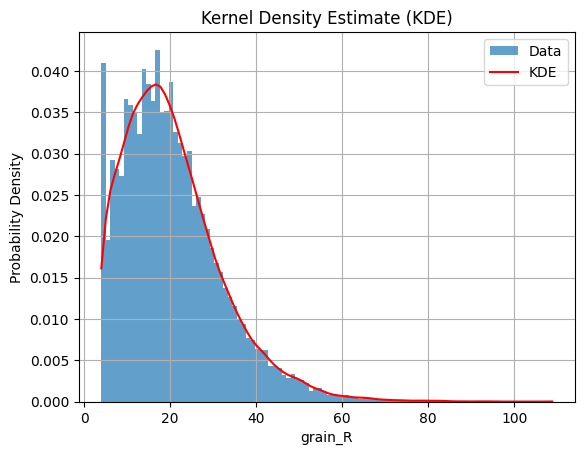

In [36]:
# Create the histogram plot
plt.hist(grain_R, bins=100, density=True, alpha=0.7, label='Data')

# Fit a KDE to the data
kde = gaussian_kde(grain_R)

# Generate x values for the plot
x = np.linspace(min(grain_R), max(grain_R), 100)

# Compute the KDE values
kde_values = kde(x)

# Plot the KDE
plt.plot(x, kde_values, 'r-', label='KDE')

plt.xlabel('grain_R')
plt.ylabel('Probability Density')
plt.title('Kernel Density Estimate (KDE)')
plt.legend()
plt.grid(True)
plt.show()

# Implement Wasserstein GAN

In [37]:
# data of grains (shape (30218, 2))
# Load into DataLoader

def compute_gp(netD, real_data, fake_data):
    batch_size = real_data.size(0)
    device = real_data.device

    # Reshape real_data and fake_data to have shape (N, 1)
    real_data = real_data.view(batch_size, 1).to(device)
    fake_data = fake_data.view(batch_size, 1).to(device)

    # Sample Epsilon from uniform distribution
    eps = torch.rand(batch_size, 1).to(device)

    # Interpolation between real data and fake data
    interpolation = eps * real_data + (1 - eps) * fake_data

    # Get logits for interpolated data
    interp_logits = netD(interpolation)

    # Compute Gradients
    gradients = autograd.grad(
        outputs=interp_logits,
        inputs=interpolation,
        grad_outputs=torch.ones_like(interp_logits).to(device),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Compute and return Gradient Norm
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)
    return torch.mean((grad_norm - 1) ** 2)


#for data in data_loader:
    # data is a batch of size (batch_size, 2)
    # Do whatever you want with it
    #print(data.shape)

In [38]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Generator
class Generator(nn.Module):
    def __init__(self, latent_Gaussian_dimension, number_of_grain_features):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_Gaussian_dimension, 75),
            nn.ReLU(),
            nn.Linear(75, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, number_of_grain_features)
        )

    def forward(self, x):
        return self.model(x)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, number_of_grain_features):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(number_of_grain_features, 25),
            nn.ReLU(),
            nn.Linear(25, 50),
            nn.ReLU(),
            nn.Linear(50, 75),
            nn.ReLU(),
            nn.Linear(75, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Use binary cross-entropy loss


def generator_loss(discriminator, fake_grains):
    """Loss computed to train the GAN generator.

    Args:
      netD: The discriminator whose forward function takes inputs of shape (batch_size, 2)
         and produces outputs of shape (batch_size, 1).
      fake_grains of shape (batch_size, 2): Fake grains produces by the generator.

    Returns:
      loss: The mean of the binary cross-entropy losses computed for all the samples in the batch.

    Notes:
    - Make sure that you process on the device given by `fake_grains.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # Ensure that the target tensor has the same device as the input fake_grains
    target = torch.full((fake_grains.size(0),), real_label, device=fake_grains.device)
    
    # Forward pass through the discriminator with the fake grains
    output = discriminator(fake_grains).view(-1)
    
    # Compute the binary cross-entropy loss between the output and the target
    loss = F.binary_cross_entropy(output, target, reduction='mean')
    
    return loss

def discriminator_loss(discriminator, real_grains, fake_grains):
    """Loss computed to train the GAN discriminator.

    Args:
      discriminator: The discriminator.
      real_grains of shape (batch_size, 2): Real grains.
      fake_grains of shape (batch_size, 2): Fake grains produces by the generator.

    Returns:
      d_loss_real: The mean of the binary cross-entropy losses computed on the real_grains.
      D_real: Mean output of the discriminator for real_grains. This is useful for tracking convergence.
      d_loss_fake: The mean of the binary cross-entropy losses computed on the fake_grains.
      D_fake: Mean output of the discriminator for fake_grains. This is useful for tracking convergence.

    Notes:
    - Make sure that you process on the device given by `fake_grains.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    # Ensure that the target tensors have the same device as the input grains
    device = fake_grains.device  # Get the device of the input tensors
    
    # Transfer input tensors to the same device as the discriminator
    real_grains = real_grains.to(device)
    fake_grains = fake_grains.to(device)
    
    # Create the target labels for real and fake grains
    real_target = torch.full((real_grains.size(0),), real_label, device=device)
    fake_target = torch.full((fake_grains.size(0),), fake_label, device=device)
    
    # Compute the discriminator outputs for real and fake grains
    real_output = discriminator(real_grains).view(-1)
    fake_output = discriminator(fake_grains).view(-1)
    
    # Compute the binary cross-entropy losses
    d_loss_real = nn.BCELoss()(real_output, real_target)
    d_loss_fake = nn.BCELoss()(fake_output, fake_target)
    
    # Compute the mean discriminator outputs for real and fake grains
    D_real = real_output.mean().item()
    D_fake = fake_output.mean().item()
    
    return d_loss_real, D_real, d_loss_fake, D_fake



### Testing shapes and loss value

In [39]:
# Test generator loss
def test_generator_loss():
    # Create a generator
    netG = Generator(latent_Gaussian_dimension=2, number_of_grain_features=2)
    netD = Discriminator(number_of_grain_features=2)
    # Create fake grains
    noise = torch.randn(100, 2)
    fake_grains = netG(noise)
    # Compute the generator loss
    loss = generator_loss(netD, fake_grains)
    print(loss)

test_generator_loss()

tensor(0.6315, grad_fn=<BinaryCrossEntropyBackward0>)


In [40]:
# Test discriminator loss
def test_discriminator_loss():
    # Create a generator
    netG = Generator(latent_Gaussian_dimension=2, number_of_grain_features=2)
    netD = Discriminator(number_of_grain_features=2)
    # Create real and fake grains
    real_grains = torch.randn(100, 2)
    noise = torch.randn(100, 2)
    fake_grains = netG(noise)
    # Compute the discriminator loss
    d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_grains, fake_grains)
    print(d_loss_real)
    print(D_real)
    print(d_loss_fake)
    print(D_fake)

test_discriminator_loss()

tensor(0.7006, grad_fn=<BinaryCrossEntropyBackward0>)
0.4963092803955078
tensor(0.6873, grad_fn=<BinaryCrossEntropyBackward0>)
0.4970460534095764


In [41]:
def test_Generator_shapes():
    netG = Generator(100, 2)

    batch_size = 32
    noise = torch.randn(batch_size, 100)
    out = netG(noise)

    assert out.shape == torch.Size([batch_size, 2]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Generator_shapes()

Success


In [42]:
def test_Discriminator_shapes():
    netD = Discriminator(2)

    batch_size = 32
    noise = torch.randn(batch_size, 2)
    out = netD(noise)

    assert out.shape == torch.Size([batch_size, 1]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Discriminator_shapes()

Success


In [43]:


# Initialize generator and discriminator
latent_Gaussian_dimension = 100  # Dimension of the input noise vector
number_of_grain_features = 2  # Dimension of the real data
#real_data_dim = 30218  # Dimension of the real data
number_of_reduced_grains = 1000  # Dimension of the generated data

generator = Generator(latent_Gaussian_dimension, number_of_grain_features).to(device)
discriminator = Discriminator(number_of_grain_features).to(device)

# Define optimizer. The paper mentions using RMSProp
#generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
#discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

generator_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define batch size
batch_size = 64

# Create DataLoader
dataloader = DataLoader(grainsData, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 2000

for epoch in range(num_epochs + 1):
    for batch_index, real_grains in enumerate(dataloader):
        real_grains = real_grains.to(torch.float32)
        #print(real_grains.dtype)
        #print(real_grains.shape)
        # real_grains is of shape (batch_size, number_of_grain_features)

        ################################
        # Update Discriminator network #
        ################################

        discriminator.zero_grad()

        noise = torch.randn(batch_size, latent_Gaussian_dimension, device=device, dtype=torch.float32)
        fake_grains = generator(noise)

        #print(fake_grains)
        #print(fake_grains.dtype)
        #print(fake_grains.shape)

        #time.sleep(60)
        # Compute discriminator loss
        d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(discriminator, real_grains, fake_grains)
        d_loss = d_loss_real + d_loss_fake
        
        # Update discriminator
        d_loss.backward()
        discriminator_optimizer.step()
        
        ############################
        # Update Generator network
        ###########################
        generator_optimizer.zero_grad()
        
        # Generate fake grains
        noise = torch.randn(batch_size, latent_Gaussian_dimension, device=device)
        fake_grains = generator(noise)
        
        # Compute generator loss
        g_loss = generator_loss(discriminator, fake_grains)
        
        # Update generator
        g_loss.backward()
        generator_optimizer.step()
            
    ############################
    # Print training progress
    ###########################
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}")
        print(f"Discriminator Loss: D_real={D_real:.4f}, D_fake={D_fake:.4f}")
        print(f"Generator Loss: {g_loss:.4f}")
    
    if epoch % 5 == 0:
        with torch.no_grad():
            # Generate fake grains and save into csv file
            generate_times = 20
            # for each epoch, we wil generate 20 different groups of fake grains as generator is random
            outputPath = f"downsampled_grains/epoch_{epoch}"
            if os.path.exists(outputPath):
                # remove the directory if it exists and create new
                shutil.rmtree(outputPath)
                os.makedirs(outputPath)
            else:
                os.makedirs(outputPath)
            
            for i in range(generate_times):  
                outputPathIndex = f"downsampled_grains/epoch_{epoch}" 
                noise = torch.randn(number_of_reduced_grains, latent_Gaussian_dimension, device=device)
                fake_grains = generator(noise)
                fake_grains = fake_grains.cpu().numpy()
                #print(fake_grains.shape)
                # Save as csv file, use pandas
                columns = ["grain_R", "grain_asp"]
                df = pd.DataFrame(fake_grains, columns=columns)
                df.to_csv(f"{outputPathIndex}/grains_{i+1}.csv", index=False)

Epoch 0
Discriminator Loss: D_real=0.9774, D_fake=0.3200
Generator Loss: 1.1528
Epoch 5
Discriminator Loss: D_real=0.5929, D_fake=0.4193
Generator Loss: 1.1813
Epoch 10
Discriminator Loss: D_real=0.4580, D_fake=0.4856
Generator Loss: 0.6522
Epoch 15
Discriminator Loss: D_real=0.5141, D_fake=0.5179
Generator Loss: 0.7206
Epoch 20
Discriminator Loss: D_real=0.4825, D_fake=0.4830
Generator Loss: 0.6711
Epoch 25
Discriminator Loss: D_real=0.4386, D_fake=0.4546
Generator Loss: 0.4839
Epoch 30
Discriminator Loss: D_real=0.4433, D_fake=0.4602
Generator Loss: 0.5284
Epoch 35
Discriminator Loss: D_real=0.4736, D_fake=0.4693
Generator Loss: 0.7054
Epoch 40
Discriminator Loss: D_real=0.4651, D_fake=0.4721
Generator Loss: 0.5923
Epoch 45
Discriminator Loss: D_real=0.5229, D_fake=0.5295
Generator Loss: 0.7736
Epoch 50
Discriminator Loss: D_real=0.4972, D_fake=0.4950
Generator Loss: 0.6971
Epoch 55
Discriminator Loss: D_real=0.4906, D_fake=0.4839
Generator Loss: 0.8150
Epoch 60
Discriminator Loss: D

KeyboardInterrupt: 

#### For the implementation of the WGAN
two feedforward neural networks were applied: One as the discriminator and one as the
generator. For the activation functions a ReLu function was used for all but the Output layer of the
discriminator, which uses a Sigmoid function, since the result of this layer has to be a probability and
Sigmoid functions give results between 0 and 1. For all of these implementations, the Pytorch
library was used

The most important ones are the width and depth of the network, as explained above. These two hyperparameters are key for the training
process, since they determine the number of neurons and the depth of the network. For each neuron,
a weight exists as was explained above. By adapting the weights of the neurons for each processed
batch the network actually learns the target distribution. Therefore, the number of neurons in a
layer, as well as the amount of layers contributes immensely to the quality of the trained NN. Thus,
width and depth were iteratively fitted in this study. This was done by training multiple NN with
varying hyperparameter sets (especially for width and depth), which were changed iteratively in a
looped approach. Therefore the parameter sets to be tested were defined before the training and then
subsequently tested.

the training data set is split into many, randomly-generated sub sets. The algorithm processes each
mini batch separately and compares the cost function in relation to the current mini batch data.
Subsequently, the network parameters are updated accordingly. This is done iterating over all mini
batches, until the whole data set has been evaluated. This complete process is called an epoch. For the
training in this study, a batch size of 64 was used, 

However, the learning rate was automatically adapted, since an optimisation
algorithm called RMSProp was used for the back propagation. This optimisation approach requires a low
learning rate which is inherent to WGAN networks. Thus the influence of these parameters is negligible.
Two important parameters are the clipping value and the dropout. Both variables represent values that
are important in the NN to avoid overfitting and underfitting

When the framework is defined, the training of the NN begins. Since the NN changes slightly after
every epoch, it is important to create intermediate snapshots of the NN, as well as the output data in the
form of a CSV file after a defined number of epochs, 200 in the case of this study. Additionally, only a
defined number of epochs should be trained, since MLA are prone to overfitting in higher epochs.

After the training of all the different NN for multiple parameter sets is complete, the best fit needs
to be found. To do so, a script was written, which creates a KDE of every microstructural parameter
taken into account for the MLA training. Additionally, the KDE of every taken snapshot are created of
the same parameters, since this is the output of the generator network. Subsequently the fit between
the input KDE and synthetic data KDE are evaluated. This is done by investigating three types of
deviation between the KDE of the real and synthetic data: The mean deviation, maximum deviation,
and mean value of both mean and maximum deviation. All three are returned and can be checked by
the user. Ideally, a NN snapshot can be chosen that shows the smallest deviation for all three values in
comparison to the rest of the NN.